In [58]:
import numpy as np
import pandas as pd
import os, sys
import matplotlib.pyplot as plt
import skimage.io
from skimage.transform import resize
import cv2
from imgaug import augmenters as iaa
from tqdm import tqdm
import PIL
from PIL import Image, ImageOps
from sklearn.utils import class_weight, shuffle
from keras.losses import binary_crossentropy
from keras.applications.resnet50 import preprocess_input
import keras.backend as K
import tensorflow as tf
from sklearn.metrics import f1_score, fbeta_score
from keras.utils import Sequence
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import warnings
import shutil
warnings.filterwarnings("ignore")

WORKERS = 2
CHANNEL = 3
IMG_SIZE = 512
NUM_CLASSES = 5
SEED = 77
TRAIN_NUM = 1000 # use 1000 when you just want to explore new idea, use -1 for full train
path_from = './data/raw/train_images/'
#path_to = './data/pre/test_images/'
path_to = './data/temp/'

In [52]:
df_train = pd.read_csv('./data/train.csv')
df_test = pd.read_csv('./data/test.csv')

x = df_train['id_code']
y = df_train['diagnosis']

x, y = shuffle(x, y, random_state=SEED)

def crop_image_from_gray(img,tol=7):
    if img.ndim ==2:
        mask = img>tol
        return img[np.ix_(mask.any(1),mask.any(0))]
    elif img.ndim==3:
        gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        mask = gray_img>tol
        
        check_shape = img[:,:,0][np.ix_(mask.any(1),mask.any(0))].shape[0]
        if (check_shape == 0): # image is too dark so that we crop out everything,
            return img # return original image
        else:
            img1=img[:,:,0][np.ix_(mask.any(1),mask.any(0))]
            img2=img[:,:,1][np.ix_(mask.any(1),mask.any(0))]
            img3=img[:,:,2][np.ix_(mask.any(1),mask.any(0))]
    #         print(img1.shape,img2.shape,img3.shape)
            img = np.stack([img1,img2,img3],axis=-1)
    #         print(img.shape)
        return img
    
def load_ben_color(path, sigmaX=10):
    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = crop_image_from_gray(image)
    #image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
    image=cv2.addWeighted ( image,4, cv2.GaussianBlur( image , (0,0) , sigmaX) ,-4 ,128)
        
    return image

def circle_crop(img, sigmaX=10):   
    """
    Create circular crop around image centre    
    """    
    
    img = cv2.imread(img)
    img = crop_image_from_gray(img)    
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    height, width, depth = img.shape    
    
    x = int(width/2)
    y = int(height/2)
    r = np.amin((x,y))
    
    circle_img = np.zeros((height, width), np.uint8)
    cv2.circle(circle_img, (x,y), int(r), 1, thickness=-1)
    img = cv2.bitwise_and(img, img, mask=circle_img)
    img = crop_image_from_gray(img)
    #img = cv2.resize(img,(224,224))
    img=cv2.addWeighted ( img,4, cv2.GaussianBlur( img , (0,0) , sigmaX) ,-4 ,128)
    return img 

In [70]:
if os.path.exists(path_to) == False:
    os.mkdir(path_to)

cnt = 0
for idd in x.values:
    if cnt > 10:
        break
    cnt += 1
    path = path_from + idd + '.png'
    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = crop_image_from_gray(image)
    image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
    image=cv2.addWeighted ( image,4, cv2.GaussianBlur( image , (0,0) , 30) ,-4 ,128)
    path = path_to + idd + '.png'
    cv2.imwrite(path,image)

In [ ]:
if os.path.exists(path_to) == False:
    os.mkdir(path_to)

for sx in range(110,510,10):
    path_to_to = path_to + '{}/'.format(sx)
    if os.path.exists(path_to_to):
        shutil.rmtree(path_to_to)
    os.mkdir(path_to_to)
    cnt0 = 0
    cnt2 = 0
    for idd, diagnos in zip(x.values,y.values):
        flag = False
        if diagnos == 0 and cnt0 < 10:
            cnt0 +=1
            flag = True    
        if diagnos == 2 and cnt2 < 10:
            cnt2 +=1
            flag = True
        if flag == False:
            continue
        path = path_from + idd + '.png'
        #print(path)
        #img = circle_crop(path,sigmaX=30)
        img = load_ben_color(path, sx)
        path = path_to_to + idd + '_{}'.format(diagnos) + '.png'
        print(path)
        cv2.imwrite(path,img)
   

./data/temp/110/aafe980edd0c_0.png
./data/temp/110/2c2aa057afc5_2.png
./data/temp/110/42a67337fa8e_2.png
./data/temp/110/98e44127872f_0.png
./data/temp/110/3abac0961bfd_0.png
./data/temp/110/57f5ad4b5b29_0.png
./data/temp/110/bdc6c60e9133_0.png
./data/temp/110/82e5bc01f8a4_0.png
./data/temp/110/4b6cb0bcfd44_0.png
./data/temp/110/3823acc4e464_0.png
./data/temp/110/5ead17e894ae_0.png
./data/temp/110/a26f50218b84_0.png
./data/temp/110/e12d41e7b221_2.png
./data/temp/110/03676c71ed1b_2.png
./data/temp/110/1438288bb2e1_2.png
./data/temp/110/91e2c2890c9f_2.png
./data/temp/110/879744b9dc65_2.png
./data/temp/110/a7b0d0c51731_2.png
./data/temp/110/e65a2ff90494_2.png
./data/temp/110/2bd4d4fbed5c_2.png
./data/temp/120/aafe980edd0c_0.png
./data/temp/120/2c2aa057afc5_2.png
./data/temp/120/42a67337fa8e_2.png
./data/temp/120/98e44127872f_0.png
./data/temp/120/3abac0961bfd_0.png
./data/temp/120/57f5ad4b5b29_0.png
./data/temp/120/bdc6c60e9133_0.png
./data/temp/120/82e5bc01f8a4_0.png
./data/temp/120/4b6c

./data/temp/220/91e2c2890c9f_2.png
./data/temp/220/879744b9dc65_2.png
./data/temp/220/a7b0d0c51731_2.png
./data/temp/220/e65a2ff90494_2.png
./data/temp/220/2bd4d4fbed5c_2.png
./data/temp/230/aafe980edd0c_0.png
./data/temp/230/2c2aa057afc5_2.png
./data/temp/230/42a67337fa8e_2.png
./data/temp/230/98e44127872f_0.png
./data/temp/230/3abac0961bfd_0.png
./data/temp/230/57f5ad4b5b29_0.png
./data/temp/230/bdc6c60e9133_0.png
./data/temp/230/82e5bc01f8a4_0.png
./data/temp/230/4b6cb0bcfd44_0.png
./data/temp/230/3823acc4e464_0.png
./data/temp/230/5ead17e894ae_0.png
./data/temp/230/a26f50218b84_0.png
./data/temp/230/e12d41e7b221_2.png
./data/temp/230/03676c71ed1b_2.png
./data/temp/230/1438288bb2e1_2.png
./data/temp/230/91e2c2890c9f_2.png
./data/temp/230/879744b9dc65_2.png
./data/temp/230/a7b0d0c51731_2.png
./data/temp/230/e65a2ff90494_2.png
./data/temp/230/2bd4d4fbed5c_2.png
./data/temp/240/aafe980edd0c_0.png
./data/temp/240/2c2aa057afc5_2.png
./data/temp/240/42a67337fa8e_2.png
./data/temp/240/98e4

In [132]:
x[1000]

'47e51065b819'

(3112,) (3112,) (550,) (550,)


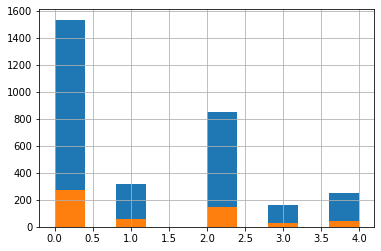

In [25]:
train_x, valid_x, train_y, valid_y = train_test_split(x, y, test_size=0.15,
                                                      stratify=y, random_state=SEED)
print(train_x.shape, train_y.shape, valid_x.shape, valid_y.shape)
train_y.hist()
valid_y.hist()

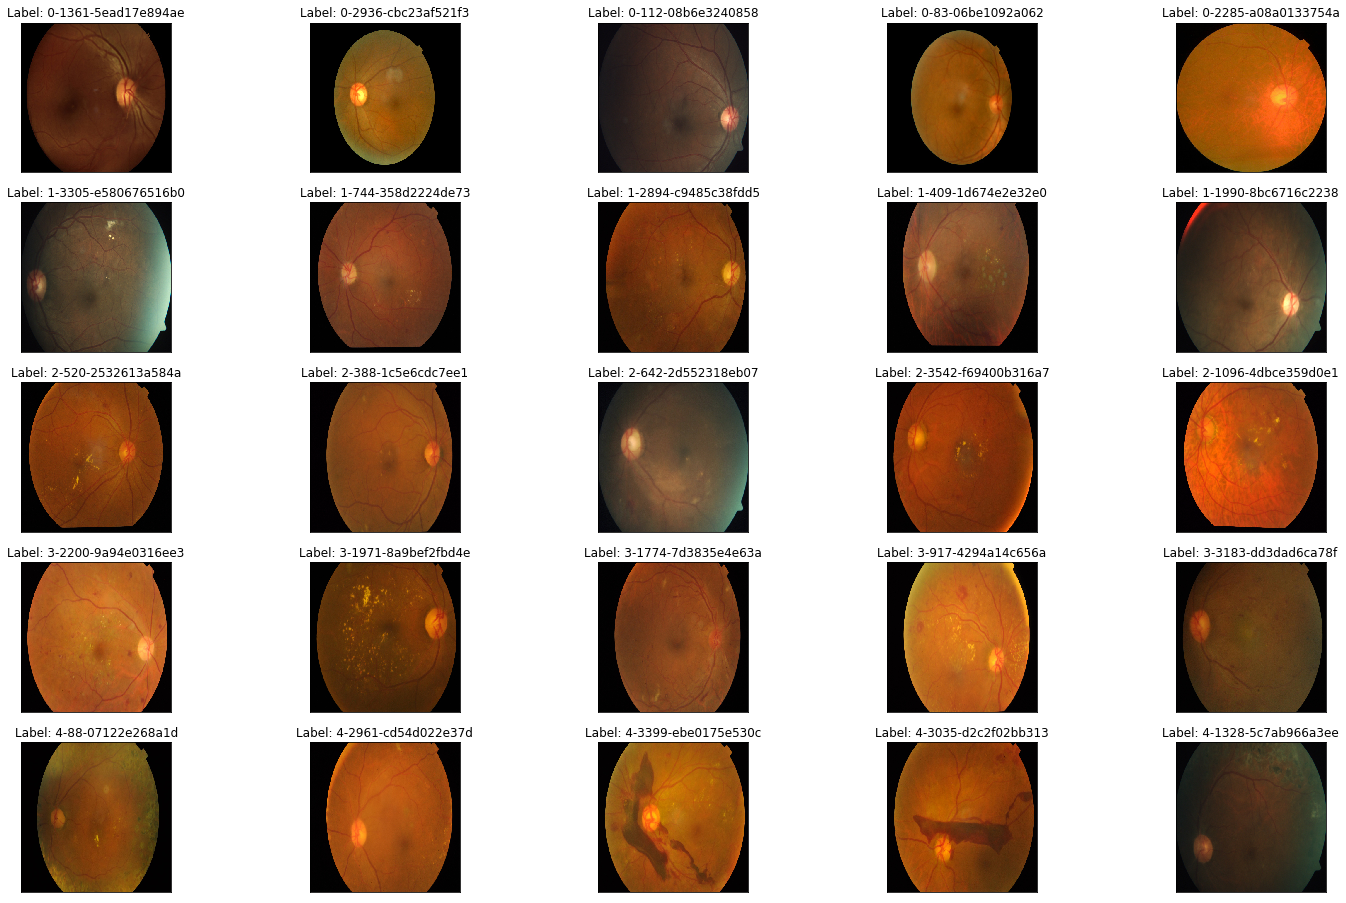

In [35]:
fig = plt.figure(figsize=(25, 16))
# display 10 images from each class
for class_id in sorted(train_y.unique()):
    for i, (idx, row) in enumerate(df_train.loc[df_train['diagnosis'] == class_id].sample(5, random_state=SEED).iterrows()):
        ax = fig.add_subplot(5, 5, class_id * 5 + i + 1, xticks=[], yticks=[])
        path=f"./train_images/{row['id_code']}.png"
        image = cv2.imread(path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))

        plt.imshow(image)
        ax.set_title('Label: %d-%d-%s' % (class_id, idx, row['id_code']) )

Wall time: 3.67 s


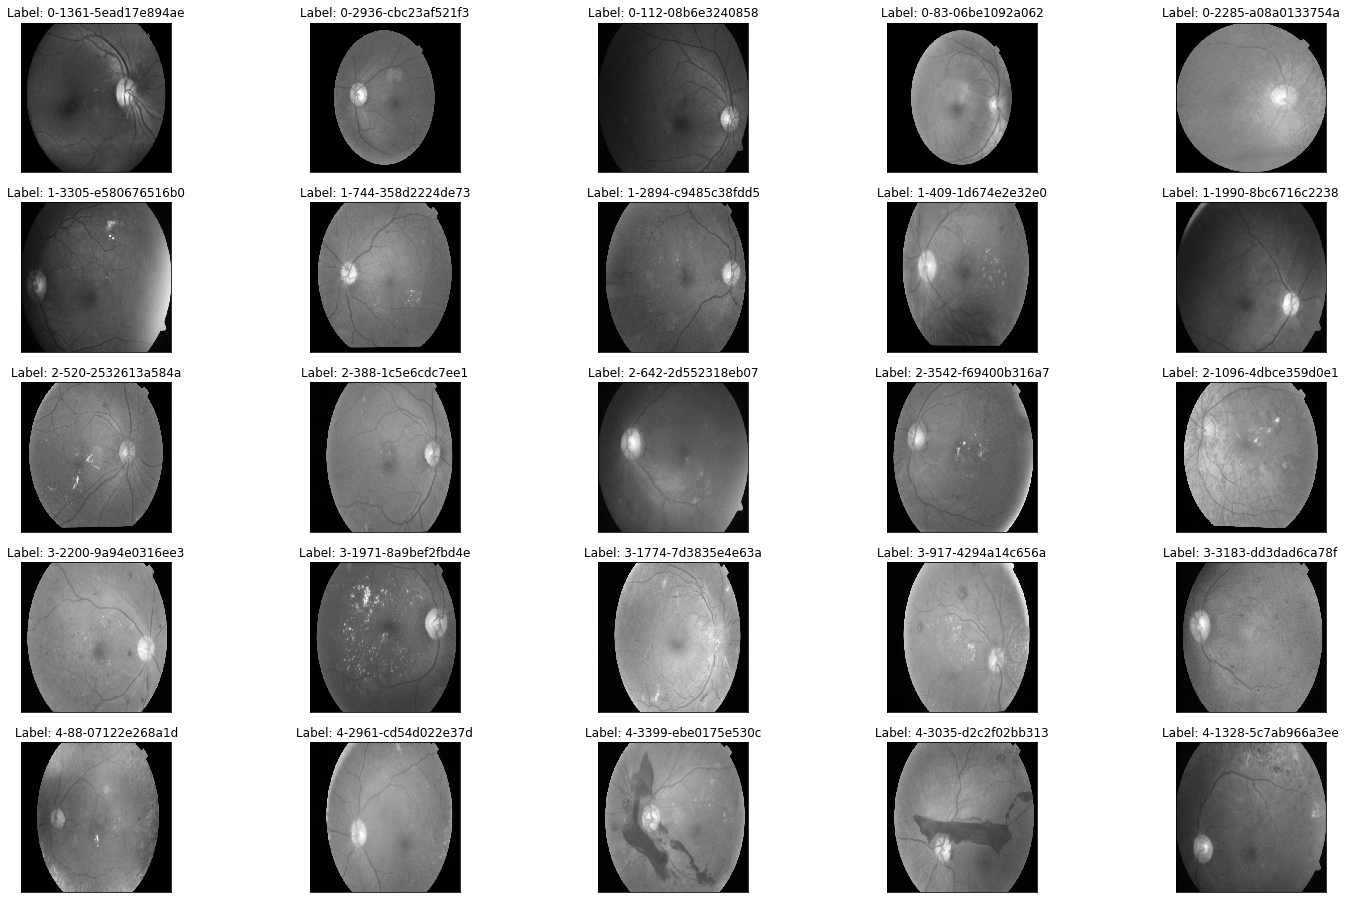

In [39]:
%%time
fig = plt.figure(figsize=(25, 16))
for class_id in sorted(train_y.unique()):
    for i, (idx, row) in enumerate(df_train.loc[df_train['diagnosis'] == class_id].sample(5, random_state=SEED).iterrows()):
        ax = fig.add_subplot(5, 5, class_id * 5 + i + 1, xticks=[], yticks=[])
        path=f"./train_images/{row['id_code']}.png"
        image = cv2.imread(path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
#         image=cv2.addWeighted ( image, 0 , cv2.GaussianBlur( image , (0 ,0 ) , 10) ,-4 ,128)
        image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))

        plt.imshow(image, cmap='gray')
        ax.set_title('Label: %d-%d-%s' % (class_id, idx, row['id_code']) )

Wall time: 8.64 s


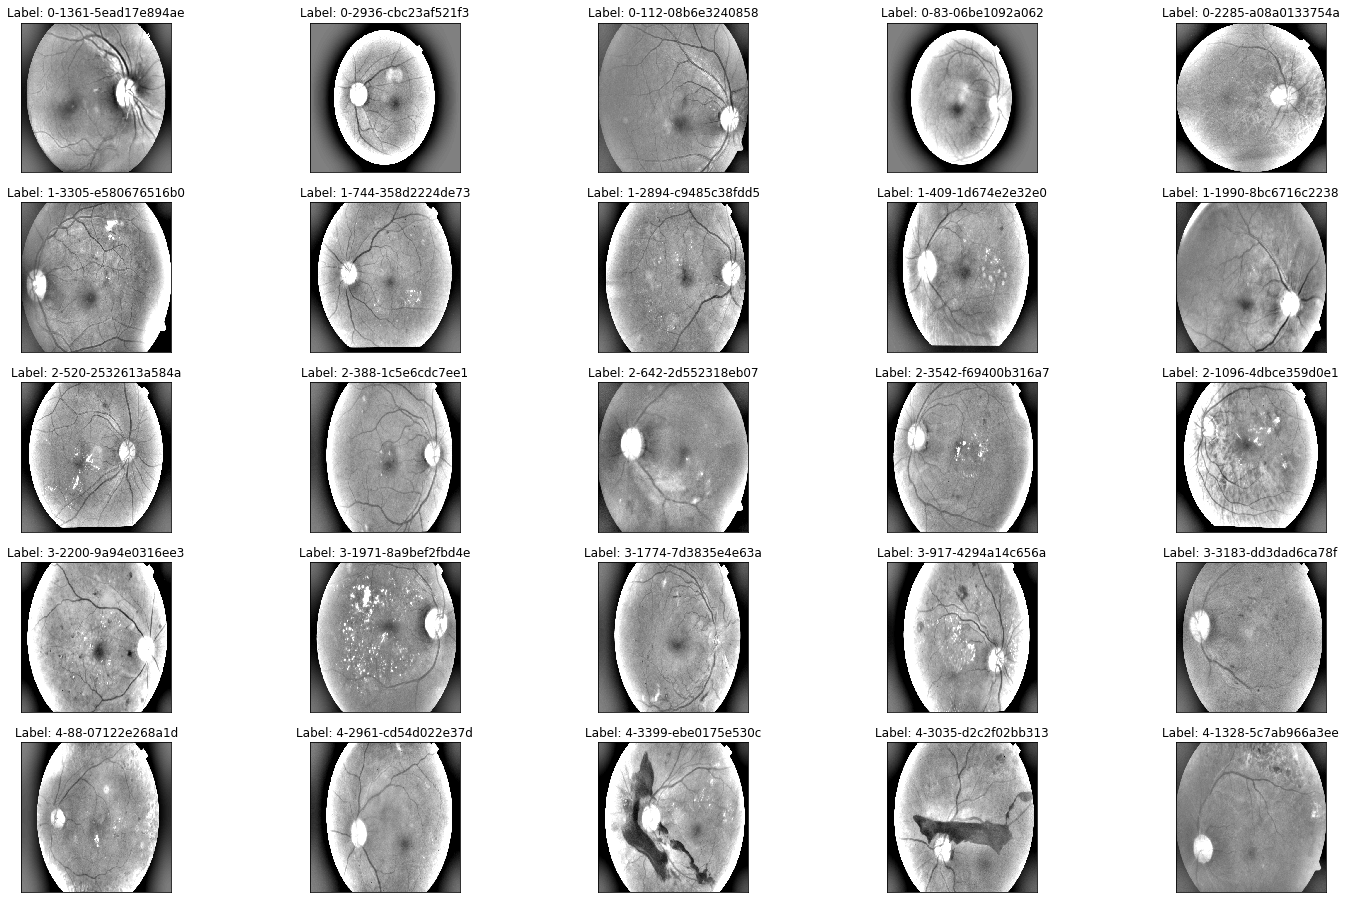

In [40]:
%%time
fig = plt.figure(figsize=(25, 16))
for class_id in sorted(train_y.unique()):
    for i, (idx, row) in enumerate(df_train.loc[df_train['diagnosis'] == class_id].sample(5, random_state=SEED).iterrows()):
        ax = fig.add_subplot(5, 5, class_id * 5 + i + 1, xticks=[], yticks=[])
        path=f"./train_images/{row['id_code']}.png"
        image = cv2.imread(path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
#         image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
        image=cv2.addWeighted ( image,4, cv2.GaussianBlur( image , (0,0) , IMG_SIZE/10) ,-4 ,128) # the trick is to add this line

        plt.imshow(image, cmap='gray')
        ax.set_title('Label: %d-%d-%s' % (class_id, idx, row['id_code']) )

In [108]:
def crop_image_from_gray(img,tol=7):
    if img.ndim ==2:
        mask = img>tol
        return img[np.ix_(mask.any(1),mask.any(0))]
    elif img.ndim==3:
        gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        mask = gray_img>tol
        
        check_shape = img[:,:,0][np.ix_(mask.any(1),mask.any(0))].shape[0]
        if (check_shape == 0): # image is too dark so that we crop out everything,
            return img # return original image
        else:
            img1=img[:,:,0][np.ix_(mask.any(1),mask.any(0))]
            img2=img[:,:,1][np.ix_(mask.any(1),mask.any(0))]
            img3=img[:,:,2][np.ix_(mask.any(1),mask.any(0))]
    #         print(img1.shape,img2.shape,img3.shape)
            img = np.stack([img1,img2,img3],axis=-1)
    #         print(img.shape)
        return img
    
def load_ben_color(path, sigmaX=10):
    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = crop_image_from_gray(image)
    image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
    image=cv2.addWeighted ( image,4, cv2.GaussianBlur( image , (0,0) , sigmaX) ,-4 ,128)
        
    return image

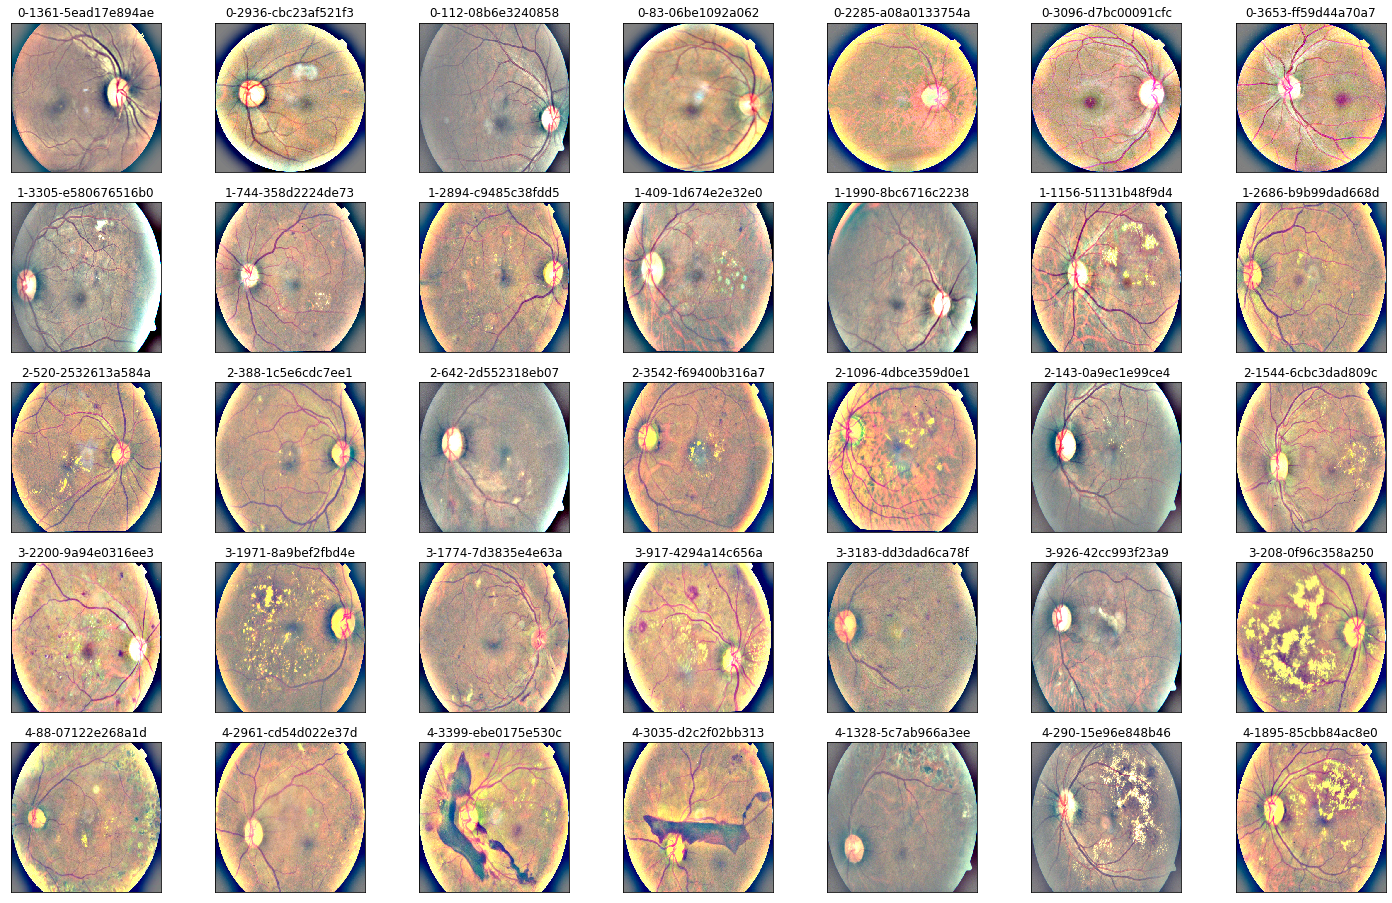

In [93]:
NUM_SAMP=7
fig = plt.figure(figsize=(25, 16))
for class_id in sorted(train_y.unique()):
    for i, (idx, row) in enumerate(df_train.loc[df_train['diagnosis'] == class_id].sample(NUM_SAMP, random_state=SEED).iterrows()):
        ax = fig.add_subplot(5, NUM_SAMP, class_id * NUM_SAMP + i + 1, xticks=[], yticks=[])
        path=f"./train_images/{row['id_code']}.png"
        image = load_ben_color(path,sigmaX=30)

        plt.imshow(image)
        ax.set_title('%d-%d-%s' % (class_id, idx, row['id_code']) )

In [94]:
def circle_crop(img, sigmaX=10):   
    """
    Create circular crop around image centre    
    """    
    
    img = cv2.imread(img)
    img = crop_image_from_gray(img)    
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    height, width, depth = img.shape    
    
    x = int(width/2)
    y = int(height/2)
    r = np.amin((x,y))
    
    circle_img = np.zeros((height, width), np.uint8)
    cv2.circle(circle_img, (x,y), int(r), 1, thickness=-1)
    img = cv2.bitwise_and(img, img, mask=circle_img)
    img = crop_image_from_gray(img)
    img=cv2.addWeighted ( img,4, cv2.GaussianBlur( img , (0,0) , sigmaX) ,-4 ,128)
    return img 

Wall time: 30.3 s


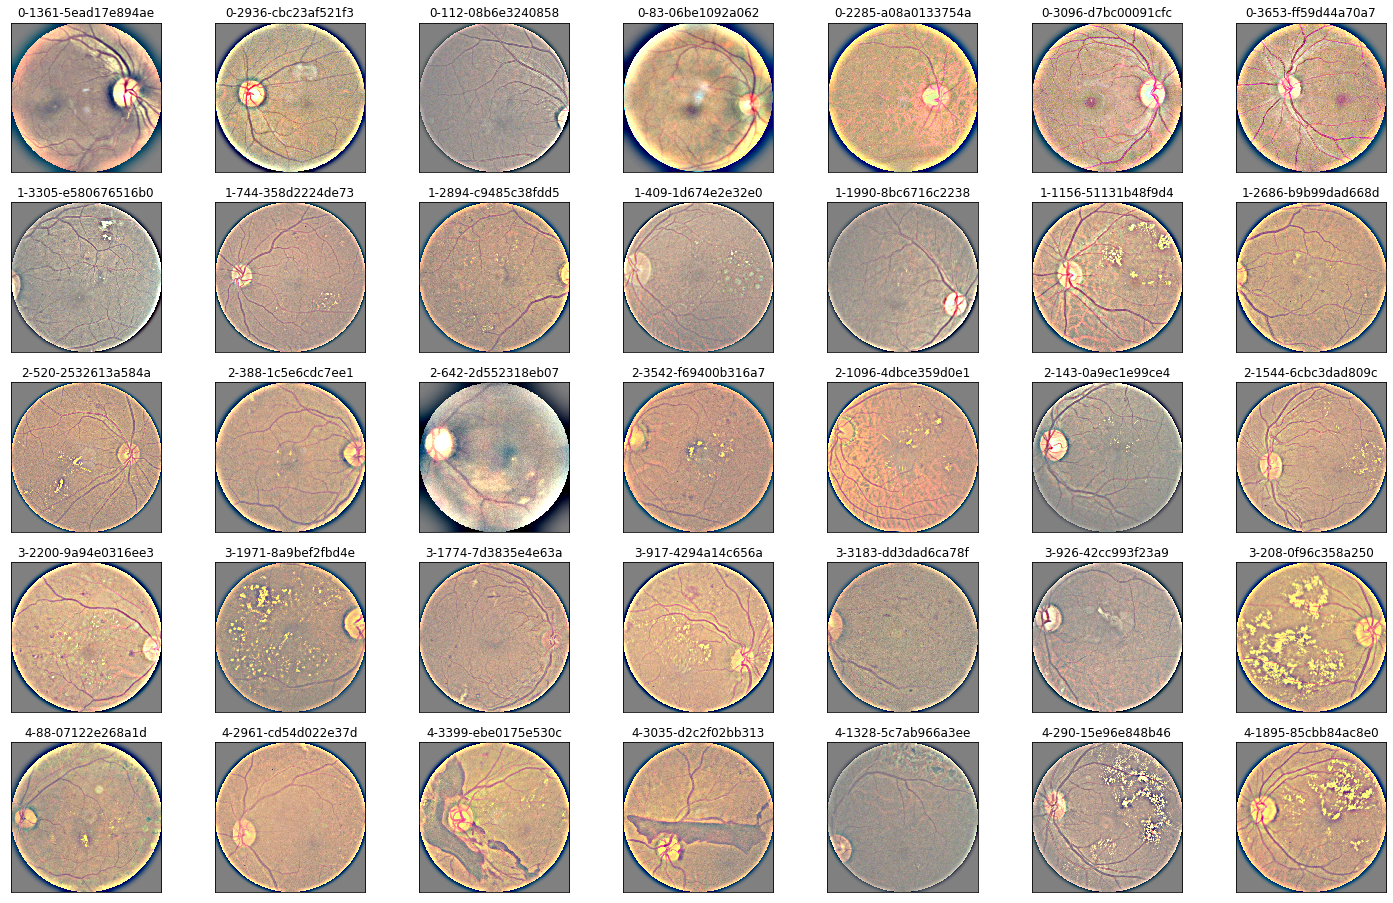

In [95]:
%%time
## try circle crop
NUM_SAMP=7
fig = plt.figure(figsize=(25, 16))
for class_id in sorted(train_y.unique()):
    for i, (idx, row) in enumerate(df_train.loc[df_train['diagnosis'] == class_id].sample(NUM_SAMP, random_state=SEED).iterrows()):
        ax = fig.add_subplot(5, NUM_SAMP, class_id * NUM_SAMP + i + 1, xticks=[], yticks=[])
        path=f"./train_images/{row['id_code']}.png"
        image = circle_crop(path,sigmaX=30)

        plt.imshow(image)
        ax.set_title('%d-%d-%s' % (class_id, idx, row['id_code']) )

Wall time: 9.31 s


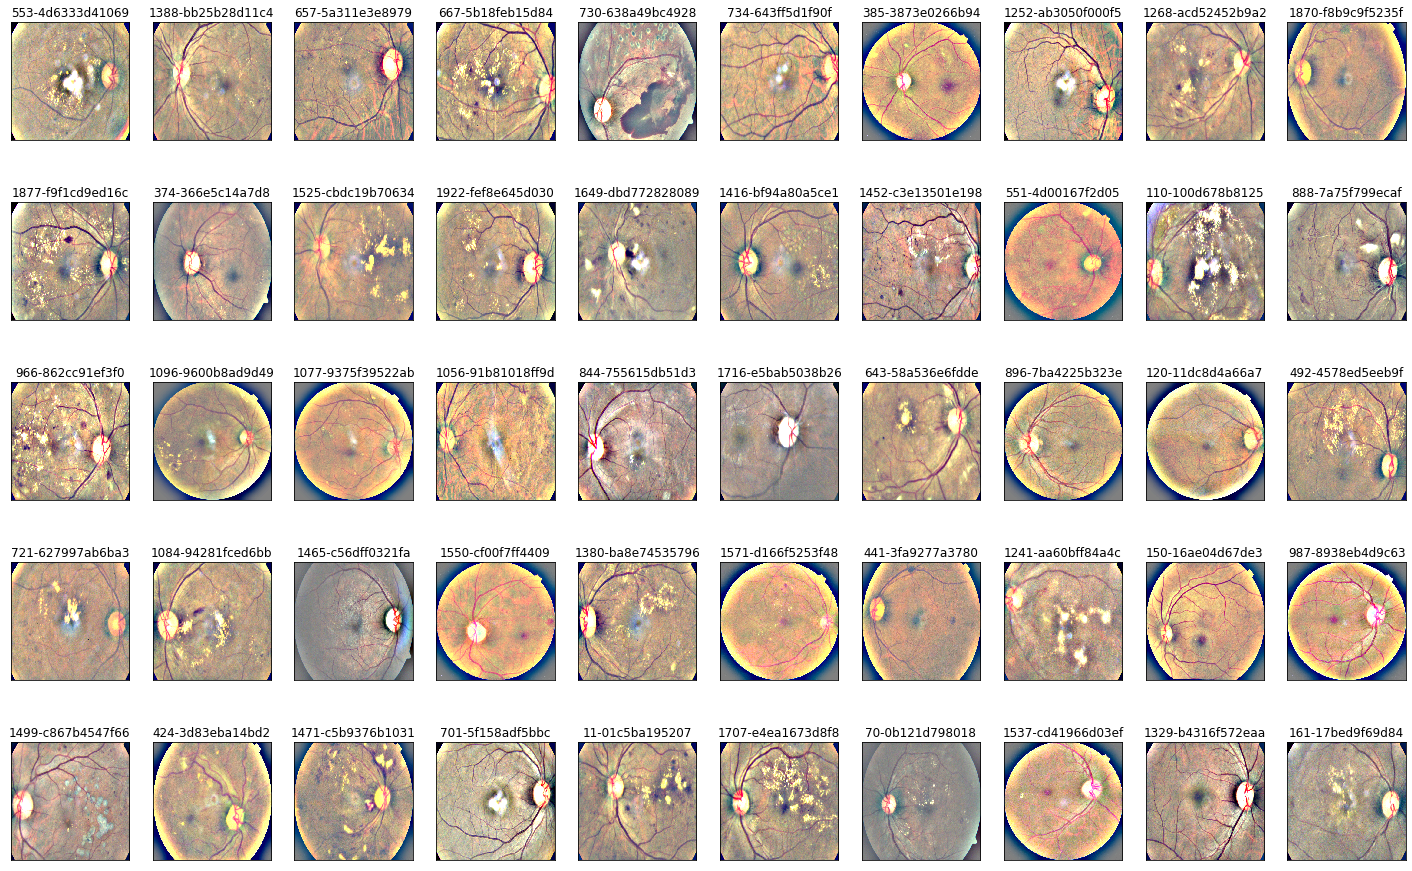

In [103]:
%%time
NUM_SAMP=10
fig = plt.figure(figsize=(25, 16))
for jj in range(5):
    for i, (idx, row) in enumerate(df_test.sample(NUM_SAMP,random_state=SEED+jj).iterrows()):
        ax = fig.add_subplot(5, NUM_SAMP, jj * NUM_SAMP + i + 1, xticks=[], yticks=[])
        path=f"./data/raw/test_images/{row['id_code']}.png"
        image = load_ben_color(path,sigmaX=30)
        
        plt.imshow(image)
        ax.set_title('%d-%s' % (idx, row['id_code']) )

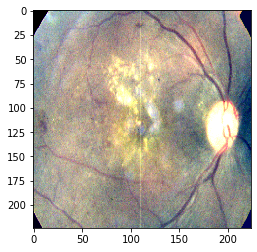

In [109]:
image = load_ben_color(path,sigmaX=30)
plt.imshow(image)

In [112]:
cv2.imwrite('./xxx.png',image)

True